# **Reinforcement Learning: Taller 4**
## Estudiantes: Juan Pablo Reyes Fajardo y Santiago Rodríguez Ávila 

In [6]:
import gymnasium as gym
import numpy as np
import itertools
import operator
from tqdm import tqdm

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

import visualkeras

In [ ]:
env = gym.make('CartPole-v1')

# 1. RL Tabular

In [ ]:
# Funcion Auxiliar para diccionarios
def key_max(d):
        return max(d.items(), key=operator.itemgetter(1))
def key_min(d):
        return min(d.items(), key=operator.itemgetter(1))

Política $\epsilon$ - Greedy 

(Útil más adelante)

In [ ]:
def eps_greedy(Q_, state,epsilon=0.1):
    rand = np.random.uniform()
    if rand>epsilon:
        return key_max(Q_[state])[0],1-epsilon
    else:
        return key_min(Q_[state])[0],epsilon

## Discretización

Inicialmente se realizan múltiples experimentos para determinar límites razonables para las variables a discretizar (aquellas cuyo espacio de observación es infinito)

In [ ]:
velocidades_absolutas_maximas={"Lineal":[],"Angular":[]}

observation, info = env.reset()

abs_lineal=abs(observation[1])
abs_angular=abs(observation[3])

for _ in range(int(1e6)):
    
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    
    if abs(observation[1])>abs_lineal:
        abs_lineal=abs(observation[1])
    if abs(observation[3])>abs_angular:
        abs_angular=abs(observation[3])

    if terminated or truncated:
        observation, info = env.reset()
        velocidades_absolutas_maximas["Lineal"].append(abs_lineal)
        velocidades_absolutas_maximas["Angular"].append(abs_angular)

env.close()

vel_lin_abs_max=np.mean(velocidades_absolutas_maximas["Lineal"])
vel_ang_abs_max=np.mean(velocidades_absolutas_maximas["Angular"])
print(f'Promedio de velocidad lineal absoluta máxima: \
      {vel_lin_abs_max} \
      \nPromedio de velocidad angular absoluta máxima: \
      {vel_ang_abs_max}')

Discretización de estados:

In [ ]:
# Límites del espacio de observación del MDP real
cart_high_var = env.observation_space.high
cart_low_var = env.observation_space.low

# Espacios de observación discretizados
observation_space_discrete_400=[np.linspace(cart_low_var[0], cart_high_var[0], num= 5),\
                            np.linspace(-vel_lin_abs_max, vel_lin_abs_max, num= 4),\
                            np.linspace(cart_low_var[2], cart_high_var[2], num = 5),\
                            np.linspace(-vel_ang_abs_max, vel_ang_abs_max, num= 4)]\

observation_space_discrete_4096=[np.linspace(cart_low_var[0], cart_high_var[0], num= 8),\
                            np.linspace(-vel_lin_abs_max, vel_lin_abs_max, num= 8),\
                            np.linspace(cart_low_var[2], cart_high_var[2], num = 8),\
                            np.linspace(-vel_ang_abs_max, vel_ang_abs_max, num= 8)]

# Uso de iteradores para obtener todos los estados a partir del espacio de obsevación discreto
states_400=list(itertools.product(*observation_space_discrete_400))
states_4096=list(itertools.product(*observation_space_discrete_4096))

def init_Q_400():
    Q_table={}
    for i in states_400:
        Q_table[i] = {0:0,1:0}
    return Q_table

def init_Q_4096():
    Q_table={}
    for i in states_4096:
        Q_table[i] = {0:0,1:0}
    return Q_table
         
def discretize_400(new_state):
    # car pos, car vel, pole angle, pole vel
    discretizacion=[0]*4
    for i in range(len(discretizacion)):
        dif = [(abs(x - new_state[i])) for x in observation_space_discrete_400[i]]
        discretizacion[i] = observation_space_discrete_400[i][dif.index(min(dif))]
        
    return tuple(discretizacion)

def discretize_4096(new_state):
    # car pos, car vel, pole angle, pole vel
    discretizacion=[0]*4
    for i in range(len(discretizacion)):
        dif = [(abs(x - new_state[i])) for x in observation_space_discrete_4096[i]]
        discretizacion[i] = observation_space_discrete_4096[i][dif.index(min(dif))]
        
    return tuple(discretizacion)

## Estimación de Q con Q-Learning 

### 400 Estados

In [ ]:
def Q_Learning_400(gamma,alpha):
    terminated=False
    observation, info = env.reset()
    observation=discretize_400(observation)
    while not terminated:
        
        action,_=eps_greedy(Q,observation,0.1)
        
        observation_, reward, terminated, truncated, info = env.step(action)
        observation_=discretize_400(observation_)
        
        Q_=key_max(Q[observation_])[1]

        Q[observation][action]+=alpha*(reward+gamma*Q_-Q[observation][action])
        observation=observation_

In [ ]:
env = gym.make('CartPole-v1',render_mode='human')
Q=init_Q_400()
policy=dict.fromkeys(states_400, 0)
for i in range(0,10):
    Q_Learning_400(0.9,0.1)

In [ ]:
def Q_Learning_4096(gamma,alpha):
    terminated=False
    observation, info = env.reset()
    observation=discretize_4096(observation)
    while not terminated:
        
        action,_=eps_greedy(Q,observation,0.1)
        
        observation_, reward, terminated, truncated, info = env.step(action)
        observation_=discretize_4096(observation_)
        
        Q_=key_max(Q[observation_])[1]

        Q[observation][action]+=alpha*(reward+gamma*Q_-Q[observation][action])
        observation=observation_

In [ ]:
env = gym.make('CartPole-v1')
Q=init_Q_4096()
policy=dict.fromkeys(states_4096, 0)
    
for i in tqdm(range(int(1e6))):
    Q_Learning_4096(0.9,0.1)

In [ ]:
for state_4096 in states_4096:
    policy[state_4096],_=eps_greedy(Q,tuple(state_4096),0)

In [ ]:

env = gym.make('CartPole-v1',render_mode="human")


rwds=[]
for _ in range(100):
    observation, info = env.reset()
    r=0
    while True:
        action = policy[discretize_4096(observation)]
        observation, reward, terminated, truncated, info = env.step(action)
        r+=reward

        if terminated or truncated:
            observation, info = env.reset()
            rwds.append(r)
            break
env.close()
print(np.mean(rwds))

In [8]:

ENV_NAME = 'CartPole-v1'


# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)

nb_actions = env.action_space.n

model = Sequential(
    [
        Flatten(input_shape=(1,) + env.observation_space.shape),
        Dense(16, activation="relu"),
        Dense(2, activation="linear"),
    ]
)


print(model.summary())

policy = EpsGreedyQPolicy()

memory = SequentialMemory(limit=50000, window_length=1)

dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               target_model_update=1e-2, policy=policy)

dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])

dqn.fit(env, nb_steps=100, visualize=True, verbose=2)

visualkeras.layered_view(model)

dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=5, visualize=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 16)                80        
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________
None
Training for 100 steps ...


ValueError: Error when checking input: expected flatten_1_input to have shape (1, 4) but got array with shape (1, 2)

In [1]:

!python --version
print('NumPy', np.__version__)
print('Tensorflow', tensorflow.__version__)

Python 3.9.13


NameError: name 'np' is not defined

In [26]:
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory


from rl.callbacks import Callback

class EpisodeRewardCallback(Callback):
    def __init__(self):
        super(EpisodeRewardCallback, self).__init__()
        self.episode_rewards = []

    def on_episode_end(self, episode, logs):
        episode_reward = logs['episode_reward']
        self.episode_rewards.append(episode_reward)
        print(f"Episode {episode + 1} reward: {episode_reward}")

# Create an instance of the callback
episode_callback = EpisodeRewardCallback()

ENV_NAME = 'CartPole-v0'


# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(4))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=int(1e5), window_length=1)
policy = EpsGreedyQPolicy()

dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.

dqn.fit(env, nb_steps=int(1e5), visualize=False, verbose=2,callbacks=[episode_callback])

# After training is done, we save the final weights.
dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=5, visualize=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 20        
_________________________________________________________________
activation_15 (Activation)   (None, 4)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 10        
_________________________________________________________________
activation_16 (Activation)   (None, 2)                 0         
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
None
Training for 100000 steps ...


/opt/conda/lib/python3.6/site-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Episode 1 reward: 82.0
    82/100000: episode: 1, duration: 1.317s, episode steps: 82, steps per second: 62, episode reward: 82.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.512 [0.000, 1.000], mean observation: 0.042 [-0.402, 0.731], loss: 0.457013, mean_absolute_error: 0.505343, mean_q: 0.056611
Episode 2 reward: 33.0
   115/100000: episode: 2, duration: 0.187s, episode steps: 33, steps per second: 176, episode reward: 33.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.515 [0.000, 1.000], mean observation: 0.157 [-0.151, 1.048], loss: 0.404588, mean_absolute_error: 0.475813, mean_q: 0.115570
Episode 3 reward: 52.0
   167/100000: episode: 3, duration: 0.335s, episode steps: 52, steps per second: 155, episode reward: 52.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.519 [0.000, 1.000], mean observation: 0.082 [-0.299, 1.016], loss: 0.384792, mean_absolute_error: 0.473673, mean_q: 0.182906
Episode 4 reward: 41.0
   208/100000: episode: 4, duration: 0.266s, episod

Episode 29 reward: 15.0
  1015/100000: episode: 29, duration: 0.087s, episode steps: 15, steps per second: 171, episode reward: 15.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.400 [0.000, 1.000], mean observation: 0.115 [-0.555, 1.244], loss: 0.354892, mean_absolute_error: 2.394433, mean_q: 4.705206
Episode 30 reward: 15.0
  1030/100000: episode: 30, duration: 0.088s, episode steps: 15, steps per second: 171, episode reward: 15.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.467 [0.000, 1.000], mean observation: 0.102 [-0.553, 1.169], loss: 0.428847, mean_absolute_error: 2.465823, mean_q: 4.823096
Episode 31 reward: 17.0
  1047/100000: episode: 31, duration: 0.096s, episode steps: 17, steps per second: 176, episode reward: 17.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.412 [0.000, 1.000], mean observation: 0.070 [-0.819, 1.331], loss: 0.468106, mean_absolute_error: 2.566093, mean_q: 4.933160
Episode 32 reward: 13.0
  1060/100000: episode: 32, duration: 0.093

Episode 56 reward: 12.0
  1357/100000: episode: 56, duration: 0.081s, episode steps: 12, steps per second: 149, episode reward: 12.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.333 [0.000, 1.000], mean observation: 0.090 [-1.011, 1.621], loss: 2.073461, mean_absolute_error: 4.172506, mean_q: 7.859346
Episode 57 reward: 11.0
  1368/100000: episode: 57, duration: 0.075s, episode steps: 11, steps per second: 147, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.273 [0.000, 1.000], mean observation: 0.114 [-1.000, 1.734], loss: 1.386971, mean_absolute_error: 4.053177, mean_q: 7.793995
Episode 58 reward: 11.0
  1379/100000: episode: 58, duration: 0.073s, episode steps: 11, steps per second: 152, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.273 [0.000, 1.000], mean observation: 0.116 [-0.956, 1.704], loss: 1.299281, mean_absolute_error: 4.117334, mean_q: 7.889252
Episode 59 reward: 9.0
  1388/100000: episode: 59, duration: 0.055s

Episode 84 reward: 12.0
  1679/100000: episode: 84, duration: 0.085s, episode steps: 12, steps per second: 142, episode reward: 12.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.333 [0.000, 1.000], mean observation: 0.111 [-0.748, 1.441], loss: 2.563508, mean_absolute_error: 5.267357, mean_q: 9.861629
Episode 85 reward: 11.0
  1690/100000: episode: 85, duration: 0.079s, episode steps: 11, steps per second: 139, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.364 [0.000, 1.000], mean observation: 0.115 [-0.800, 1.389], loss: 2.727736, mean_absolute_error: 5.295441, mean_q: 9.917642
Episode 86 reward: 11.0
  1701/100000: episode: 86, duration: 0.071s, episode steps: 11, steps per second: 155, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.364 [0.000, 1.000], mean observation: 0.107 [-0.966, 1.461], loss: 2.457676, mean_absolute_error: 5.329578, mean_q: 9.991495
Episode 87 reward: 16.0
  1717/100000: episode: 87, duration: 0.120

Episode 111 reward: 14.0
  2059/100000: episode: 111, duration: 0.090s, episode steps: 14, steps per second: 155, episode reward: 14.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.429 [0.000, 1.000], mean observation: 0.088 [-0.793, 1.210], loss: 2.325088, mean_absolute_error: 5.860105, mean_q: 11.043200
Episode 112 reward: 18.0
  2077/100000: episode: 112, duration: 0.108s, episode steps: 18, steps per second: 166, episode reward: 18.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.444 [0.000, 1.000], mean observation: 0.080 [-0.578, 1.157], loss: 3.917350, mean_absolute_error: 6.043012, mean_q: 11.127014
Episode 113 reward: 14.0
  2091/100000: episode: 113, duration: 0.080s, episode steps: 14, steps per second: 174, episode reward: 14.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.429 [0.000, 1.000], mean observation: 0.113 [-0.572, 1.179], loss: 3.166391, mean_absolute_error: 5.999855, mean_q: 11.106357
Episode 114 reward: 12.0
  2103/100000: episode: 114, dura

Episode 139 reward: 17.0
  2540/100000: episode: 139, duration: 0.105s, episode steps: 17, steps per second: 162, episode reward: 17.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.471 [0.000, 1.000], mean observation: 0.086 [-0.645, 1.238], loss: 3.769333, mean_absolute_error: 6.599899, mean_q: 12.147138
Episode 140 reward: 30.0
  2570/100000: episode: 140, duration: 0.175s, episode steps: 30, steps per second: 171, episode reward: 30.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.500 [0.000, 1.000], mean observation: 0.048 [-0.398, 0.843], loss: 3.686262, mean_absolute_error: 6.626273, mean_q: 12.114931
Episode 141 reward: 20.0
  2590/100000: episode: 141, duration: 0.121s, episode steps: 20, steps per second: 165, episode reward: 20.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.500 [0.000, 1.000], mean observation: 0.085 [-0.419, 0.841], loss: 3.241905, mean_absolute_error: 6.614342, mean_q: 12.217180
Episode 142 reward: 28.0
  2618/100000: episode: 142, dura

Episode 166 reward: 27.0
  3632/100000: episode: 166, duration: 0.165s, episode steps: 27, steps per second: 164, episode reward: 27.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.519 [0.000, 1.000], mean observation: -0.071 [-1.054, 0.362], loss: 2.851150, mean_absolute_error: 7.950523, mean_q: 15.113782
Episode 167 reward: 25.0
  3657/100000: episode: 167, duration: 0.143s, episode steps: 25, steps per second: 175, episode reward: 25.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.520 [0.000, 1.000], mean observation: -0.080 [-0.932, 0.414], loss: 4.225405, mean_absolute_error: 8.086159, mean_q: 15.216100
Episode 168 reward: 20.0
  3677/100000: episode: 168, duration: 0.124s, episode steps: 20, steps per second: 161, episode reward: 20.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.500 [0.000, 1.000], mean observation: -0.076 [-0.856, 0.444], loss: 3.714986, mean_absolute_error: 8.035290, mean_q: 15.158844
Episode 169 reward: 16.0
  3693/100000: episode: 169, d

Episode 194 reward: 10.0
  4038/100000: episode: 194, duration: 0.064s, episode steps: 10, steps per second: 156, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.700 [0.000, 1.000], mean observation: -0.143 [-1.875, 1.151], loss: 4.378322, mean_absolute_error: 8.923762, mean_q: 17.015604
Episode 195 reward: 9.0
  4047/100000: episode: 195, duration: 0.054s, episode steps: 9, steps per second: 167, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.778 [0.000, 1.000], mean observation: -0.133 [-1.981, 1.226], loss: 3.744203, mean_absolute_error: 8.894413, mean_q: 16.949753
Episode 196 reward: 12.0
  4059/100000: episode: 196, duration: 0.073s, episode steps: 12, steps per second: 165, episode reward: 12.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.750 [0.000, 1.000], mean observation: -0.096 [-1.918, 1.223], loss: 5.704932, mean_absolute_error: 8.967443, mean_q: 16.855680
Episode 197 reward: 10.0
  4069/100000: episode: 197, dura

Episode 221 reward: 10.0
  4311/100000: episode: 221, duration: 0.060s, episode steps: 10, steps per second: 168, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.900 [0.000, 1.000], mean observation: -0.143 [-2.706, 1.720], loss: 6.609975, mean_absolute_error: 9.593665, mean_q: 17.907705
Episode 222 reward: 10.0
  4321/100000: episode: 222, duration: 0.063s, episode steps: 10, steps per second: 158, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 1.000 [1.000, 1.000], mean observation: -0.159 [-3.107, 1.942], loss: 5.901322, mean_absolute_error: 9.558410, mean_q: 17.933226
Episode 223 reward: 9.0
  4330/100000: episode: 223, duration: 0.066s, episode steps: 9, steps per second: 136, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 1.000 [1.000, 1.000], mean observation: -0.122 [-2.785, 1.803], loss: 8.417294, mean_absolute_error: 9.719343, mean_q: 18.046442
Episode 224 reward: 10.0
  4340/100000: episode: 224, dura

Episode 250 reward: 9.0
  4595/100000: episode: 250, duration: 0.064s, episode steps: 9, steps per second: 142, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.889 [0.000, 1.000], mean observation: -0.137 [-2.303, 1.395], loss: 5.313713, mean_absolute_error: 9.769633, mean_q: 18.289791
Episode 251 reward: 12.0
  4607/100000: episode: 251, duration: 0.077s, episode steps: 12, steps per second: 156, episode reward: 12.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.750 [0.000, 1.000], mean observation: -0.099 [-2.137, 1.380], loss: 8.986015, mean_absolute_error: 9.919201, mean_q: 18.226797
Episode 252 reward: 9.0
  4616/100000: episode: 252, duration: 0.061s, episode steps: 9, steps per second: 148, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.889 [0.000, 1.000], mean observation: -0.149 [-2.285, 1.368], loss: 8.378172, mean_absolute_error: 9.960607, mean_q: 18.351091
Episode 253 reward: 12.0
  4628/100000: episode: 253, duratio

Episode 277 reward: 49.0
  5313/100000: episode: 277, duration: 0.284s, episode steps: 49, steps per second: 173, episode reward: 49.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.510 [0.000, 1.000], mean observation: 0.113 [-0.237, 0.920], loss: 3.913048, mean_absolute_error: 9.512217, mean_q: 18.072205
Episode 278 reward: 28.0
  5341/100000: episode: 278, duration: 0.167s, episode steps: 28, steps per second: 168, episode reward: 28.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.500 [0.000, 1.000], mean observation: 0.111 [-0.161, 0.916], loss: 4.699475, mean_absolute_error: 9.624839, mean_q: 18.196720
Episode 279 reward: 26.0
  5367/100000: episode: 279, duration: 0.154s, episode steps: 26, steps per second: 169, episode reward: 26.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.500 [0.000, 1.000], mean observation: 0.115 [-0.274, 1.185], loss: 6.310135, mean_absolute_error: 9.699812, mean_q: 18.140228
Episode 280 reward: 27.0
  5394/100000: episode: 280, dura

Episode 304 reward: 54.0
  6613/100000: episode: 304, duration: 0.305s, episode steps: 54, steps per second: 177, episode reward: 54.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.519 [0.000, 1.000], mean observation: 0.119 [-0.412, 0.667], loss: 5.820991, mean_absolute_error: 9.906590, mean_q: 18.634323
Episode 305 reward: 118.0
  6731/100000: episode: 305, duration: 0.658s, episode steps: 118, steps per second: 179, episode reward: 118.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.508 [0.000, 1.000], mean observation: 0.032 [-0.404, 0.849], loss: 4.763710, mean_absolute_error: 9.905890, mean_q: 18.745239
Episode 306 reward: 62.0
  6793/100000: episode: 306, duration: 0.349s, episode steps: 62, steps per second: 178, episode reward: 62.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.484 [0.000, 1.000], mean observation: -0.035 [-0.820, 0.619], loss: 4.658542, mean_absolute_error: 9.947299, mean_q: 18.837564
Episode 307 reward: 86.0
  6879/100000: episode: 307, 

Episode 330 reward: 69.0
  8359/100000: episode: 330, duration: 0.388s, episode steps: 69, steps per second: 178, episode reward: 69.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.493 [0.000, 1.000], mean observation: -0.065 [-0.741, 0.341], loss: 5.059013, mean_absolute_error: 11.373915, mean_q: 21.763760
Episode 331 reward: 68.0
  8427/100000: episode: 331, duration: 0.374s, episode steps: 68, steps per second: 182, episode reward: 68.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.485 [0.000, 1.000], mean observation: -0.050 [-0.739, 0.345], loss: 5.407334, mean_absolute_error: 11.452188, mean_q: 21.929550
Episode 332 reward: 37.0
  8464/100000: episode: 332, duration: 0.224s, episode steps: 37, steps per second: 165, episode reward: 37.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.459 [0.000, 1.000], mean observation: -0.109 [-0.696, 0.264], loss: 6.020202, mean_absolute_error: 11.475592, mean_q: 21.820463
Episode 333 reward: 160.0
  8624/100000: episode: 33

Episode 356 reward: 43.0
 10185/100000: episode: 356, duration: 0.246s, episode steps: 43, steps per second: 175, episode reward: 43.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.465 [0.000, 1.000], mean observation: -0.141 [-0.735, 0.216], loss: 5.845871, mean_absolute_error: 12.898246, mean_q: 24.918406
Episode 357 reward: 118.0
 10303/100000: episode: 357, duration: 0.672s, episode steps: 118, steps per second: 176, episode reward: 118.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.517 [0.000, 1.000], mean observation: 0.106 [-0.495, 0.770], loss: 5.207743, mean_absolute_error: 13.010008, mean_q: 25.130171
Episode 358 reward: 87.0
 10390/100000: episode: 358, duration: 0.500s, episode steps: 87, steps per second: 174, episode reward: 87.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.483 [0.000, 1.000], mean observation: -0.103 [-0.829, 0.271], loss: 5.797424, mean_absolute_error: 13.128880, mean_q: 25.339199
Episode 359 reward: 71.0
 10461/100000: episode: 3

Episode 382 reward: 83.0
 12274/100000: episode: 382, duration: 0.472s, episode steps: 83, steps per second: 176, episode reward: 83.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.494 [0.000, 1.000], mean observation: -0.100 [-1.219, 0.257], loss: 6.599673, mean_absolute_error: 14.339184, mean_q: 27.653618
Episode 383 reward: 45.0
 12319/100000: episode: 383, duration: 0.260s, episode steps: 45, steps per second: 173, episode reward: 45.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.467 [0.000, 1.000], mean observation: -0.135 [-0.710, 0.229], loss: 5.498701, mean_absolute_error: 14.439000, mean_q: 27.921032
Episode 384 reward: 200.0
 12519/100000: episode: 384, duration: 1.098s, episode steps: 200, steps per second: 182, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.515 [0.000, 1.000], mean observation: 0.056 [-0.497, 1.224], loss: 6.597198, mean_absolute_error: 14.520765, mean_q: 28.020063
Episode 385 reward: 98.0
 12617/100000: episode: 3

Episode 408 reward: 72.0
 14742/100000: episode: 408, duration: 0.392s, episode steps: 72, steps per second: 184, episode reward: 72.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.486 [0.000, 1.000], mean observation: -0.100 [-0.935, 0.418], loss: 6.155410, mean_absolute_error: 15.760193, mean_q: 30.585104
Episode 409 reward: 108.0
 14850/100000: episode: 409, duration: 0.613s, episode steps: 108, steps per second: 176, episode reward: 108.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.546 [0.000, 1.000], mean observation: 0.268 [-0.377, 1.793], loss: 7.499080, mean_absolute_error: 15.837807, mean_q: 30.676731
Episode 410 reward: 181.0
 15031/100000: episode: 410, duration: 0.998s, episode steps: 181, steps per second: 181, episode reward: 181.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.492 [0.000, 1.000], mean observation: -0.133 [-0.858, 0.338], loss: 7.164948, mean_absolute_error: 15.854271, mean_q: 30.723703
Episode 411 reward: 118.0
 15149/100000: episod

Episode 434 reward: 57.0
 17825/100000: episode: 434, duration: 0.325s, episode steps: 57, steps per second: 175, episode reward: 57.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.456 [0.000, 1.000], mean observation: -0.155 [-0.949, 0.183], loss: 7.545706, mean_absolute_error: 17.928652, mean_q: 34.923744
Episode 435 reward: 137.0
 17962/100000: episode: 435, duration: 0.808s, episode steps: 137, steps per second: 169, episode reward: 137.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.533 [0.000, 1.000], mean observation: 0.309 [-0.500, 1.859], loss: 7.263951, mean_absolute_error: 17.912479, mean_q: 34.992485
Episode 436 reward: 41.0
 18003/100000: episode: 436, duration: 0.232s, episode steps: 41, steps per second: 177, episode reward: 41.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.463 [0.000, 1.000], mean observation: -0.158 [-0.722, 0.267], loss: 5.100492, mean_absolute_error: 17.891886, mean_q: 35.180859
Episode 437 reward: 45.0
 18048/100000: episode: 4

Episode 460 reward: 57.0
 20109/100000: episode: 460, duration: 0.329s, episode steps: 57, steps per second: 174, episode reward: 57.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.474 [0.000, 1.000], mean observation: -0.172 [-0.938, 0.397], loss: 10.213633, mean_absolute_error: 19.552258, mean_q: 38.115520
Episode 461 reward: 38.0
 20147/100000: episode: 461, duration: 0.215s, episode steps: 38, steps per second: 177, episode reward: 38.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.447 [0.000, 1.000], mean observation: -0.173 [-0.744, 0.178], loss: 12.880100, mean_absolute_error: 19.689806, mean_q: 38.165436
Episode 462 reward: 93.0
 20240/100000: episode: 462, duration: 0.522s, episode steps: 93, steps per second: 178, episode reward: 93.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.473 [0.000, 1.000], mean observation: -0.068 [-0.886, 0.404], loss: 8.568763, mean_absolute_error: 19.645985, mean_q: 38.412525
Episode 463 reward: 51.0
 20291/100000: episode: 4

Episode 486 reward: 55.0
 22471/100000: episode: 486, duration: 0.310s, episode steps: 55, steps per second: 178, episode reward: 55.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.455 [0.000, 1.000], mean observation: -0.163 [-0.915, 0.396], loss: 9.101160, mean_absolute_error: 21.161612, mean_q: 41.325748
Episode 487 reward: 186.0
 22657/100000: episode: 487, duration: 1.030s, episode steps: 186, steps per second: 181, episode reward: 186.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.532 [0.000, 1.000], mean observation: 0.304 [-0.777, 2.201], loss: 9.044780, mean_absolute_error: 21.281351, mean_q: 41.622658
Episode 488 reward: 200.0
 22857/100000: episode: 488, duration: 1.078s, episode steps: 200, steps per second: 186, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.525 [0.000, 1.000], mean observation: 0.284 [-0.769, 2.021], loss: 8.460954, mean_absolute_error: 21.381245, mean_q: 41.912022
Episode 489 reward: 67.0
 22924/100000: episode:

Episode 512 reward: 141.0
 25256/100000: episode: 512, duration: 0.756s, episode steps: 141, steps per second: 186, episode reward: 141.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.475 [0.000, 1.000], mean observation: -0.103 [-1.279, 0.572], loss: 9.206371, mean_absolute_error: 23.121870, mean_q: 45.440636
Episode 513 reward: 198.0
 25454/100000: episode: 513, duration: 1.087s, episode steps: 198, steps per second: 182, episode reward: 198.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.530 [0.000, 1.000], mean observation: 0.333 [-0.524, 2.423], loss: 11.324561, mean_absolute_error: 23.374090, mean_q: 45.834366
Episode 514 reward: 200.0
 25654/100000: episode: 514, duration: 1.089s, episode steps: 200, steps per second: 184, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.520 [0.000, 1.000], mean observation: 0.199 [-0.474, 1.430], loss: 10.689075, mean_absolute_error: 23.477943, mean_q: 46.081913
Episode 515 reward: 64.0
 25718/100000: epi

Episode 538 reward: 68.0
 27644/100000: episode: 538, duration: 0.370s, episode steps: 68, steps per second: 184, episode reward: 68.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.456 [0.000, 1.000], mean observation: -0.217 [-1.266, 0.397], loss: 12.585102, mean_absolute_error: 24.852835, mean_q: 48.787533
Episode 539 reward: 103.0
 27747/100000: episode: 539, duration: 0.567s, episode steps: 103, steps per second: 182, episode reward: 103.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.466 [0.000, 1.000], mean observation: -0.153 [-1.297, 0.376], loss: 11.432095, mean_absolute_error: 25.014179, mean_q: 49.241276
Episode 540 reward: 95.0
 27842/100000: episode: 540, duration: 0.515s, episode steps: 95, steps per second: 184, episode reward: 95.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.463 [0.000, 1.000], mean observation: -0.183 [-1.319, 0.340], loss: 13.695927, mean_absolute_error: 25.075594, mean_q: 49.204288
Episode 541 reward: 102.0
 27944/100000: episo

Episode 564 reward: 116.0
 30989/100000: episode: 564, duration: 0.638s, episode steps: 116, steps per second: 182, episode reward: 116.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.466 [0.000, 1.000], mean observation: -0.222 [-1.499, 0.616], loss: 11.565417, mean_absolute_error: 26.956203, mean_q: 53.219822
Episode 565 reward: 134.0
 31123/100000: episode: 565, duration: 0.752s, episode steps: 134, steps per second: 178, episode reward: 134.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.470 [0.000, 1.000], mean observation: -0.177 [-1.414, 0.348], loss: 13.993960, mean_absolute_error: 27.140373, mean_q: 53.458309
Episode 566 reward: 136.0
 31259/100000: episode: 566, duration: 0.749s, episode steps: 136, steps per second: 182, episode reward: 136.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.471 [0.000, 1.000], mean observation: -0.153 [-1.498, 0.600], loss: 14.524711, mean_absolute_error: 27.153740, mean_q: 53.423553
Episode 567 reward: 193.0
 31452/100000:

Episode 590 reward: 143.0
 34789/100000: episode: 590, duration: 0.800s, episode steps: 143, steps per second: 179, episode reward: 143.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.469 [0.000, 1.000], mean observation: -0.230 [-1.599, 0.473], loss: 18.616835, mean_absolute_error: 29.619434, mean_q: 58.355701
Episode 591 reward: 164.0
 34953/100000: episode: 591, duration: 0.917s, episode steps: 164, steps per second: 179, episode reward: 164.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.470 [0.000, 1.000], mean observation: -0.222 [-1.854, 0.640], loss: 14.326041, mean_absolute_error: 29.606976, mean_q: 58.547161
Episode 592 reward: 151.0
 35104/100000: episode: 592, duration: 0.901s, episode steps: 151, steps per second: 168, episode reward: 151.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.470 [0.000, 1.000], mean observation: -0.222 [-1.645, 0.514], loss: 16.581055, mean_absolute_error: 29.844944, mean_q: 58.967636
Episode 593 reward: 166.0
 35270/100000:

Episode 616 reward: 200.0
 39649/100000: episode: 616, duration: 1.088s, episode steps: 200, steps per second: 184, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.515 [0.000, 1.000], mean observation: 0.198 [-0.487, 1.433], loss: 23.585434, mean_absolute_error: 32.714497, mean_q: 64.498055
Episode 617 reward: 200.0
 39849/100000: episode: 617, duration: 1.094s, episode steps: 200, steps per second: 183, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.485 [0.000, 1.000], mean observation: -0.116 [-1.076, 0.537], loss: 14.833260, mean_absolute_error: 32.972355, mean_q: 65.273529
Episode 618 reward: 171.0
 40020/100000: episode: 618, duration: 0.958s, episode steps: 171, steps per second: 179, episode reward: 171.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.468 [0.000, 1.000], mean observation: -0.290 [-2.013, 0.515], loss: 21.247639, mean_absolute_error: 33.118446, mean_q: 65.371689
Episode 619 reward: 200.0
 40220/100000: 

Episode 642 reward: 200.0
 44641/100000: episode: 642, duration: 1.091s, episode steps: 200, steps per second: 183, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.515 [0.000, 1.000], mean observation: 0.191 [-0.587, 1.459], loss: 23.340315, mean_absolute_error: 36.608589, mean_q: 72.569168
Episode 643 reward: 200.0
 44841/100000: episode: 643, duration: 1.087s, episode steps: 200, steps per second: 184, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.500 [0.000, 1.000], mean observation: -0.032 [-0.548, 0.610], loss: 22.590271, mean_absolute_error: 36.734566, mean_q: 72.747665
Episode 644 reward: 191.0
 45032/100000: episode: 644, duration: 1.046s, episode steps: 191, steps per second: 183, episode reward: 191.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.524 [0.000, 1.000], mean observation: 0.358 [-0.594, 2.434], loss: 26.302023, mean_absolute_error: 36.777069, mean_q: 72.786575
Episode 645 reward: 173.0
 45205/100000: e

Episode 668 reward: 200.0
 49650/100000: episode: 668, duration: 1.095s, episode steps: 200, steps per second: 183, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.515 [0.000, 1.000], mean observation: 0.258 [-0.619, 1.876], loss: 24.388081, mean_absolute_error: 39.628292, mean_q: 78.439957
Episode 669 reward: 200.0
 49850/100000: episode: 669, duration: 1.094s, episode steps: 200, steps per second: 183, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.520 [0.000, 1.000], mean observation: 0.328 [-0.559, 2.331], loss: 23.134954, mean_absolute_error: 39.692379, mean_q: 78.656921
Episode 670 reward: 183.0
 50033/100000: episode: 670, duration: 1.017s, episode steps: 183, steps per second: 180, episode reward: 183.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.519 [0.000, 1.000], mean observation: 0.376 [-0.483, 2.416], loss: 19.791746, mean_absolute_error: 39.694988, mean_q: 78.827774
Episode 671 reward: 195.0
 50228/100000: ep

Episode 694 reward: 179.0
 54579/100000: episode: 694, duration: 0.989s, episode steps: 179, steps per second: 181, episode reward: 179.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.520 [0.000, 1.000], mean observation: 0.396 [-0.618, 2.419], loss: 21.357538, mean_absolute_error: 42.378220, mean_q: 84.291641
Episode 695 reward: 177.0
 54756/100000: episode: 695, duration: 0.989s, episode steps: 177, steps per second: 179, episode reward: 177.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.520 [0.000, 1.000], mean observation: 0.410 [-0.811, 2.411], loss: 29.026394, mean_absolute_error: 42.576508, mean_q: 84.419373
Episode 696 reward: 200.0
 54956/100000: episode: 696, duration: 1.133s, episode steps: 200, steps per second: 177, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.515 [0.000, 1.000], mean observation: 0.304 [-0.744, 2.045], loss: 25.370377, mean_absolute_error: 42.586437, mean_q: 84.410583
Episode 697 reward: 194.0
 55150/100000: ep

Episode 720 reward: 200.0
 59687/100000: episode: 720, duration: 1.099s, episode steps: 200, steps per second: 182, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.515 [0.000, 1.000], mean observation: 0.383 [-0.883, 2.369], loss: 25.633379, mean_absolute_error: 45.192753, mean_q: 90.026810
Episode 721 reward: 200.0
 59887/100000: episode: 721, duration: 1.040s, episode steps: 200, steps per second: 192, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.515 [0.000, 1.000], mean observation: 0.359 [-0.452, 2.268], loss: 39.792461, mean_absolute_error: 45.282482, mean_q: 89.628082
Episode 722 reward: 200.0
 60087/100000: episode: 722, duration: 1.022s, episode steps: 200, steps per second: 196, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.510 [0.000, 1.000], mean observation: 0.186 [-0.523, 1.278], loss: 29.415045, mean_absolute_error: 45.172924, mean_q: 89.782928
Episode 723 reward: 200.0
 60287/100000: ep

Episode 746 reward: 200.0
 64862/100000: episode: 746, duration: 1.089s, episode steps: 200, steps per second: 184, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.510 [0.000, 1.000], mean observation: 0.318 [-0.548, 1.924], loss: 27.395039, mean_absolute_error: 47.628468, mean_q: 94.895271
Episode 747 reward: 200.0
 65062/100000: episode: 747, duration: 1.121s, episode steps: 200, steps per second: 178, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.515 [0.000, 1.000], mean observation: 0.335 [-0.748, 2.090], loss: 29.407505, mean_absolute_error: 47.886425, mean_q: 95.359688
Episode 748 reward: 200.0
 65262/100000: episode: 748, duration: 1.106s, episode steps: 200, steps per second: 181, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.510 [0.000, 1.000], mean observation: 0.242 [-0.522, 1.496], loss: 33.050728, mean_absolute_error: 47.846024, mean_q: 95.178391
Episode 749 reward: 200.0
 65462/100000: ep

Episode 772 reward: 200.0
 70062/100000: episode: 772, duration: 1.106s, episode steps: 200, steps per second: 181, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.510 [0.000, 1.000], mean observation: 0.210 [-0.571, 1.375], loss: 31.086555, mean_absolute_error: 49.961758, mean_q: 99.858986
Episode 773 reward: 200.0
 70262/100000: episode: 773, duration: 1.095s, episode steps: 200, steps per second: 183, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.510 [0.000, 1.000], mean observation: 0.171 [-0.558, 1.125], loss: 31.008905, mean_absolute_error: 50.012520, mean_q: 99.937325
Episode 774 reward: 200.0
 70462/100000: episode: 774, duration: 1.085s, episode steps: 200, steps per second: 184, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.510 [0.000, 1.000], mean observation: 0.269 [-0.606, 1.591], loss: 32.109512, mean_absolute_error: 50.133827, mean_q: 100.255508
Episode 775 reward: 200.0
 70662/100000: e

Episode 798 reward: 200.0
 75262/100000: episode: 798, duration: 1.123s, episode steps: 200, steps per second: 178, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.505 [0.000, 1.000], mean observation: 0.129 [-0.599, 0.863], loss: 30.308907, mean_absolute_error: 51.379696, mean_q: 102.902145
Episode 799 reward: 200.0
 75462/100000: episode: 799, duration: 1.119s, episode steps: 200, steps per second: 179, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.505 [0.000, 1.000], mean observation: 0.179 [-0.522, 1.085], loss: 26.413164, mean_absolute_error: 51.275955, mean_q: 102.808632
Episode 800 reward: 200.0
 75662/100000: episode: 800, duration: 1.108s, episode steps: 200, steps per second: 181, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.510 [0.000, 1.000], mean observation: 0.231 [-0.612, 1.442], loss: 30.474638, mean_absolute_error: 51.412830, mean_q: 103.066093
Episode 801 reward: 200.0
 75862/100000:

Episode 824 reward: 200.0
 80462/100000: episode: 824, duration: 1.124s, episode steps: 200, steps per second: 178, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.510 [0.000, 1.000], mean observation: 0.162 [-0.474, 1.099], loss: 25.740572, mean_absolute_error: 52.048882, mean_q: 104.435959
Episode 825 reward: 200.0
 80662/100000: episode: 825, duration: 1.114s, episode steps: 200, steps per second: 180, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.505 [0.000, 1.000], mean observation: 0.130 [-0.581, 0.905], loss: 31.576767, mean_absolute_error: 52.469845, mean_q: 105.150673
Episode 826 reward: 200.0
 80862/100000: episode: 826, duration: 1.124s, episode steps: 200, steps per second: 178, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.510 [0.000, 1.000], mean observation: 0.190 [-0.584, 1.148], loss: 25.225698, mean_absolute_error: 52.173985, mean_q: 104.777481
Episode 827 reward: 200.0
 81062/100000:

Episode 850 reward: 200.0
 85662/100000: episode: 850, duration: 1.135s, episode steps: 200, steps per second: 176, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.505 [0.000, 1.000], mean observation: 0.160 [-0.616, 1.079], loss: 36.137497, mean_absolute_error: 53.565060, mean_q: 107.391075
Episode 851 reward: 200.0
 85862/100000: episode: 851, duration: 1.127s, episode steps: 200, steps per second: 177, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.505 [0.000, 1.000], mean observation: 0.072 [-0.481, 0.691], loss: 32.197464, mean_absolute_error: 52.976559, mean_q: 106.214119
Episode 852 reward: 200.0
 86062/100000: episode: 852, duration: 1.119s, episode steps: 200, steps per second: 179, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.505 [0.000, 1.000], mean observation: 0.155 [-0.620, 0.975], loss: 25.399239, mean_absolute_error: 53.135849, mean_q: 106.664589
Episode 853 reward: 200.0
 86262/100000:

Episode 876 reward: 200.0
 90862/100000: episode: 876, duration: 1.111s, episode steps: 200, steps per second: 180, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.505 [0.000, 1.000], mean observation: 0.108 [-0.514, 0.704], loss: 22.021021, mean_absolute_error: 52.178993, mean_q: 104.757591
Episode 877 reward: 200.0
 91062/100000: episode: 877, duration: 1.128s, episode steps: 200, steps per second: 177, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.500 [0.000, 1.000], mean observation: 0.004 [-0.502, 0.663], loss: 25.356318, mean_absolute_error: 52.180176, mean_q: 104.770432
Episode 878 reward: 200.0
 91262/100000: episode: 878, duration: 1.121s, episode steps: 200, steps per second: 178, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.505 [0.000, 1.000], mean observation: 0.097 [-0.780, 0.777], loss: 18.884434, mean_absolute_error: 52.132027, mean_q: 104.805046
Episode 879 reward: 200.0
 91462/100000:

Episode 902 reward: 200.0
 96062/100000: episode: 902, duration: 1.114s, episode steps: 200, steps per second: 179, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.500 [0.000, 1.000], mean observation: 0.100 [-0.589, 0.591], loss: 27.449696, mean_absolute_error: 50.959076, mean_q: 102.092064
Episode 903 reward: 200.0
 96262/100000: episode: 903, duration: 1.092s, episode steps: 200, steps per second: 183, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.500 [0.000, 1.000], mean observation: -0.006 [-0.579, 0.591], loss: 22.757051, mean_absolute_error: 50.728466, mean_q: 101.835899
Episode 904 reward: 200.0
 96462/100000: episode: 904, duration: 1.129s, episode steps: 200, steps per second: 177, episode reward: 200.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.500 [0.000, 1.000], mean observation: 0.003 [-0.587, 0.683], loss: 24.194386, mean_absolute_error: 50.470577, mean_q: 101.281013
Episode 905 reward: 200.0
 96662/100000

In [27]:
print("All episode rewards:", episode_callback.episode_rewards)

All episode rewards: [82.0, 33.0, 52.0, 41.0, 56.0, 40.0, 43.0, 42.0, 38.0, 30.0, 44.0, 47.0, 54.0, 49.0, 31.0, 24.0, 58.0, 55.0, 25.0, 19.0, 16.0, 20.0, 16.0, 18.0, 24.0, 12.0, 18.0, 13.0, 15.0, 15.0, 17.0, 13.0, 16.0, 12.0, 12.0, 14.0, 15.0, 10.0, 15.0, 15.0, 11.0, 13.0, 11.0, 13.0, 11.0, 10.0, 12.0, 11.0, 10.0, 13.0, 11.0, 13.0, 15.0, 12.0, 10.0, 12.0, 11.0, 11.0, 9.0, 15.0, 10.0, 13.0, 14.0, 12.0, 13.0, 12.0, 13.0, 10.0, 11.0, 12.0, 10.0, 9.0, 11.0, 9.0, 10.0, 11.0, 13.0, 11.0, 11.0, 12.0, 12.0, 12.0, 13.0, 12.0, 11.0, 11.0, 16.0, 16.0, 13.0, 16.0, 14.0, 14.0, 16.0, 13.0, 10.0, 13.0, 15.0, 12.0, 12.0, 14.0, 14.0, 15.0, 16.0, 12.0, 18.0, 18.0, 16.0, 16.0, 11.0, 14.0, 14.0, 18.0, 14.0, 12.0, 12.0, 12.0, 18.0, 18.0, 19.0, 24.0, 17.0, 13.0, 20.0, 13.0, 17.0, 20.0, 19.0, 14.0, 13.0, 15.0, 18.0, 17.0, 18.0, 17.0, 22.0, 18.0, 24.0, 22.0, 17.0, 30.0, 20.0, 28.0, 14.0, 21.0, 18.0, 35.0, 43.0, 29.0, 69.0, 40.0, 35.0, 29.0, 31.0, 36.0, 37.0, 65.0, 36.0, 53.0, 27.0, 77.0, 55.0, 106.0, 30.0, 79

In [29]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

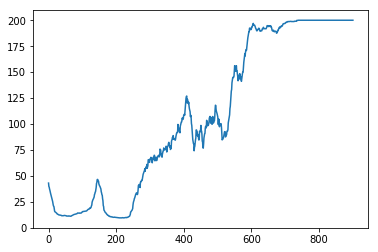

In [31]:
import matplotlib.pyplot as plt
plt.plot(running_mean(episode_callback.episode_rewards,20))
plt.show()

In [ ]:
#SARSA algorithm
def SARSA_algorithm(num_episodes):
    allowed_actions=[0,1]
    # Variables: alpha, gamma y epsilon.
    alpha = 0.3
    gamma = 1
    epsilon = 0.1
    cont = 0
    #Para 5000 episodios de entrenamiento
    for i in range(num_episodes):
        # Inicializa las variables para cada episodio
        state=env.reset()
        num_steps = 0
        state = discretize(state[0])


        # Seleccion accion "a" de forma epsilon-greedy
        if epsilon< np.random.uniform():        
            act_arg = np.array([Q_table[tuple(state), act] for act in range(2)])
            action = allowed_actions[np.argmax(act_arg)]
        else:
            action = env.action_space.sample()

        # Inicia el episodio
        continue_episode = True
        while continue_episode:        
            # Obtengo s'
            new_state, reward, done, _,_=env.step(action)
            new_state = discretize(new_state)

            # Revisa que new_state no sea un estado terminal
            if done:
                # Valor q(s',a') terminal
                q_value_next_step = 0
            else:
                #Obtengo a' de s' con epsilon greedy
                if epsilon< np.random.uniform():        
                    act_arg = np.array([Q_table[tuple(state), act] for act in range(2)])
                    new_action = allowed_actions[np.argmax(act_arg)]
                else:
                    new_action = env.action_space.sample()

                # Valor q(s',a') no terminal
                q_value_next_step = Q_table[tuple(new_state),new_action]


            # Calculo de actualizacion q(s,a) <- q(s,a) + alpha*(R + gamma*q(s',a') - q(s,a))
            Q_table[tuple(state), action] += alpha*(reward + gamma*q_value_next_step - Q_table[tuple(state),action])

            # asigna a = a' y s = s'
            state = new_state
            action = new_action


            # Parte que termina el episodio si se llega a algun estado terminal
            if done:
                continue_episode = False
        cont+=1
        if cont%100==0:
            print(cont)

## SARSA con 400 estados:

In [ ]:
set_states()
set_q_table()

In [ ]:
discrete_values = num_states(400)
SARSA_algorithm(5000)

In [ ]:
allowed_actions= [0,1]
prom=[]
prom_rand=[]
for i in range(100):
    G_pi = 0
    state =env.reset()
    state = state[0]
    state = discretize(state)
    act_arg = np.array([Q_table[tuple(state), act] for act in range(2)])
    action = allowed_actions[np.argmax(act_arg)]
    done = False
    n=1
    while not done:
        new_state, reward, done, _,_=env.step(action)
        G_pi= G_pi + reward
        discrete_state = discretize(new_state)
        act_arg = np.array([Q_table[tuple(discrete_state), act] for act in range(2)])
        action = allowed_actions[np.argmax(act_arg)]
    prom.append(G_pi)
print('---'*5)
for i in range(100):
    G_pi = 0
    state =env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        new_state, reward, done, _,_=env.step(action)
        G_pi= G_pi + reward
    prom_rand.append(G_pi)

In [ ]:
print("Retorno obtenido con la funcion q:",sum(prom)/len(prom))
print("Retorno obtenido de acciones al azar:",sum(prom_rand)/len(prom_rand))

## SARSA con 4000 estados:

In [ ]:
set_states()
set_q_table()

In [ ]:
discrete_values = num_states(4000)
SARSA_algorithm(1000)

In [ ]:
prom=[]
prom_rand=[]
allowed_actions= [0,1]
for i in range(100):
    G_pi = 0
    state =env.reset()
    state = state[0]
    state = discretize(state)
    act_arg = np.array([Q_table[tuple(state), act] for act in range(2)])
    action = allowed_actions[np.argmax(act_arg)]
    done = False
    n=1
    while not done:
        new_state, reward, done, _,_=env.step(action)
        G_pi= G_pi + reward
        discrete_state = discretize(new_state)
        act_arg = np.array([Q_table[tuple(discrete_state), act] for act in range(2)])
        action = allowed_actions[np.argmax(act_arg)]
    prom.append(G_pi)
print('---'*5)
for i in range(100):
    G_pi = 0
    state =env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        new_state, reward, done, _,_=env.step(action)
        G_pi= G_pi + reward
    prom_rand.append(G_pi)

In [ ]:
print("Retorno obtenido con la funcion q:",sum(prom)/len(prom))
print("Retorno obtenido de acciones al azar:",sum(prom_rand)/len(prom_rand))

In [ ]:
env.close()